# Version suitable to our case

The problem in the implementation above is, that training and testing data uses the electric power. Obviously they provide good results. However, our task where we want to model the behavior depending on the input beforehand is not solved.

For our task we need to implement a network where it takes the current and previous inputs to predict the electrical output. If useful, we can include the previous electrical oputput as well.

For all the data we need to implement the difference, scale all and then train the model.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import Global_Functions as gf
import matplotlib.pyplot as plt

In [2]:
import time
timestr = time.strftime("%Y-%m-%d_%H-%M")

In [3]:
OPEN_FOLDER = '../Data/Preped_Data/'

In [4]:
ex_1 = gf.open_CSV_file('experiment_1_short.csv', OPEN_FOLDER)
ex_4 = gf.open_CSV_file('experiment_4_short.csv', OPEN_FOLDER)
ex_9 = gf.open_CSV_file('experiment_9_short.csv', OPEN_FOLDER)
ex_20 = gf.open_CSV_file('experiment_20_short.csv', OPEN_FOLDER)
ex_21 = gf.open_CSV_file('experiment_21_short.csv', OPEN_FOLDER)
ex_22 = gf.open_CSV_file('experiment_22_short.csv', OPEN_FOLDER)
ex_23 = gf.open_CSV_file('experiment_23_short.csv', OPEN_FOLDER)
ex_24 = gf.open_CSV_file('experiment_24_short.csv', OPEN_FOLDER)

In [5]:
image_path = "../Images/"
image_subfolder = image_path + "RNN/"
image_folder = image_subfolder + timestr + "/"

gf.check_folder(image_path)
gf.check_folder(image_subfolder)
gf.check_folder(image_folder)

Folder already exists.
Folder already exists.
Creation of directory ../Images/RNN/2021-03-12_15-24/ successful.


In [6]:
np.random.seed(123)

In [7]:
kit_orange = gf.get_color('orange')
kit_green = gf.get_color('green')
kit_blue = gf.get_color('blue')
kit_cyan = gf.get_color('cyan')
kit_red = gf.get_color('red')
kit_lightgreen = gf.get_color('lightgreen')
kit_grey = gf.get_color('grey')

## Make time series to supervised problem

We need to restructure the data to have a supervised learning problem. Within we need to get the necessary inputs and necessary outputs as new columns.

In [8]:
def timeseries_to_supervised(data, lag = 10):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag +1)]
    df_delay = pd.concat(columns, axis = 1)
    df = pd.concat([df, df_delay], axis = 1)
    df.fillna(0, inplace = True)
    df.columns = [str("delay_" + str(i)) for i in range(0, lag +1)]
    return df

In [9]:
def difference(data, lag = 10):
    diff = list()
    for i in range(lag, len(data)):
        value = data[i] - data[i - lag]
        diff.append(value)
    return pd.Series(diff, name = data.name)

In [10]:
def invert_difference(data, yhat, index = 0):
    return yhat + data[index]

In [11]:
def scale(data_series, scaler = None):
    data = data_series.values
    data = data.reshape(-1, 1)
    if scaler is None:
        scaler = MinMaxScaler(feature_range = (-1,1), )
        scaler = scaler.fit(data)
    data_scaled = scaler.transform(data)
    return data_scaled, scaler

In [12]:
def invert_scale(scaler, value):
    return scaler.inverse_transform(value.reshape(-1,1))

In [13]:
def fit_lstm(X_train, y_train, X_val, y_val, batch_size, nb_epochs, neurons):
    X_train = X_train.values
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    
    es = EarlyStopping(monitor = "val_loss", patience = int(0.05*nb_epochs)#
                      )
    
    model = Sequential()
    model.add(layers.LSTM(neurons, batch_input_shape = (batch_size, X_train.shape[1], X_train.shape[2]), stateful = True))
    model.add(layers.Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', )
    for i in range(nb_epochs):
        model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 1, batch_size = batch_size, verbose = 1, shuffle = False, callbacks = [es])
        model.reset_states()
    return model

In [14]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(X.shape[0], 1, X.shape[1])
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [15]:
def prepare_data(data, lag):
    diff_values = difference(data, lag)
    diff_scaled, scaler = scale(diff_values)
    supervised = timeseries_to_supervised(diff_scaled, lag)
    return supervised, scaler

Methods are completed now execution

In [16]:
# lag = 50

In [17]:
# train_input, scaler_input = prepare_data(ex_20['input_voltage'], lag)
# train_el_power, scaler_el = prepare_data(ex_20['el_power'], lag)

In [18]:
# lstm_model = fit_lstm(train_input, train_el_power['delay_0'], 1, 10, 300)

In [19]:
# X_train = train_input.values

# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

# y_train = train_el_power['delay_0']

In [20]:
# X_train[390:400]

In [21]:
# train_preds_scaled = lstm_model.predict(X_train, batch_size = 1)

In [22]:
# plt.plot(train_el_power['delay_0'])
# plt.plot(train_preds_scaled)

In [23]:
# def predictions(X_test, y_test):
#     predictions = list()
#     for i in range(len(X_test)):
#         #make forecast
#         yhat = forecast_lstm(lstm_model, 1, X_test[i, :])
#         #invert scaling
#         yhat = invert_scale(scaler_el, yhat)
#         #invert differencing
#         yhat = invert_difference(X_test, yhat, i-len(X_test))
#         #store forecast
#         predictions.append(yhat)
#     return predictions

In [24]:
#  preds_train = predictions(X_train, y_train)

In [25]:
#  preds = [preds_train[i][0][-1] for i in range(len(preds_train))]

In [26]:
# plt.plot(preds)

## Second try

We do all from scratch building our own data frame and using scaling and preparation of data according to our understanding

In [27]:
df = ex_20

In [28]:
def prepare_data(df, lag_input = 1, lag_output = 1):
    length = len(df)
    input_scaled, scaler_input = scale(df['input_voltage'])
    power_scaled, scaler_power = scale(df['el_power'])
    
    scaler = [scaler_input, scaler_power]
    
    input_scaled = [x[0] for x in input_scaled]
    power_scaled = [x[0] for x in power_scaled]
    
    input_scaled = np.append(input_scaled, np.full(lag_input, -1))
    power_scaled = np.append(power_scaled, np.full(lag_output, -1))
    
    input_scaled_diff = np.roll(input_scaled, lag_input)
    power_scaled_diff = np.roll(power_scaled, lag_output)
    
    df = pd.DataFrame()
    df['input_voltage'] = input_scaled[:length]
    df['input_voltage_delay_' + str(lag_input)] = input_scaled_diff[:length]
    df['el_power'] = power_scaled[:length]
    df['el_power_delay_' + str(lag_output)] = power_scaled_diff[:length]
    
    y = df[['el_power']]
    X = df.drop(['el_power'], axis = 1)
    
    return scaler, X, y

In [29]:
def train_model(experiment_train, experiment_val, lag_input = 1, lag_output = 1, batch_size = 1, neurons = 8, nb_epochs = 10):
    scaler_train, X_train, y_train = prepare_data(experiment_train, lag_input, lag_output)
    scaler_val, X_val, y_val = prepare_data(experiment_val, lag_input, lag_output)
    X_val = X_val.values
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
    model = fit_lstm(X_train, y_train, X_val, y_val, batch_size, neurons, nb_epochs)
    
    return model, scaler_train, X_train, y_train, scaler_val, X_val, y_val

In [30]:
model_20, scaler_20, X_20, y_20, scaler_21, X_21, y_21 = train_model(ex_20, ex_21, lag_input=1, lag_output = 1, batch_size=1, neurons=128, nb_epochs=300)

6958/6958 [==============================] - 16s 2ms/step - loss: 0.0016 - val_loss: 0.1328


6958/6958 [==============================] - 15s 2ms/step - loss: 0.0011 - val_loss: 0.3467


In [31]:
def predictions(experiment, model, batch_size = 1, specs = ""):
    scaler, X, y = prepare_data(experiment)
    
    X = X.values
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    preds_scaled = model.predict(X, batch_size = batch_size)
    preds = scaler[1].inverse_transform(preds_scaled)
    
    fig = plt.figure(figsize = (15,10))
    plt.plot(experiment['el_power'], color = gf.get_color("grey"), label = "True")
    plt.plot(preds, color = gf.get_color("green"), label = "Predictions")
    plt.ylabel('Electric power in [W]')
    plt.xlabel('Time')
    plt.legend()
    plt.title('Comparison predictions to true values' + specs, fontsize = 14)
    fig.tight_layout()
    plt.show()
    fig.savefig(image_folder + specs + "predictions.png")
    fig.savefig(image_folder + specs + "predictions.svg")
    
    return scaler, X, y, preds_scaled, preds

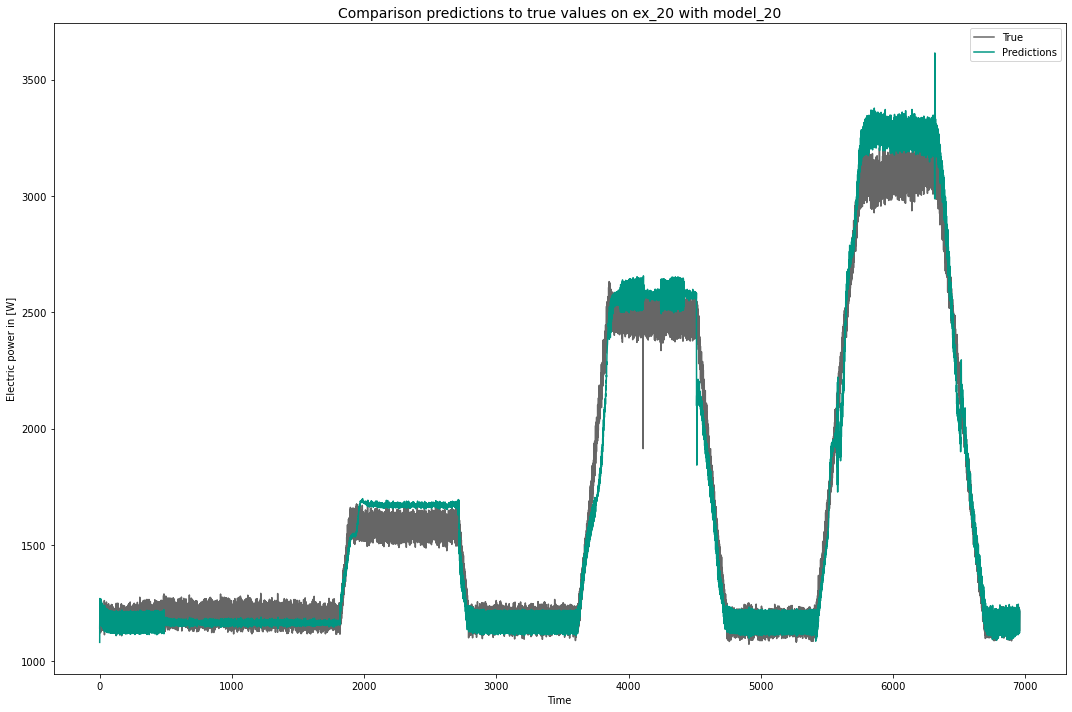

In [32]:
_, _, _, preds_scaled_20, preds_20 = predictions(ex_20, model_20, specs = " on ex_20 with model_20")

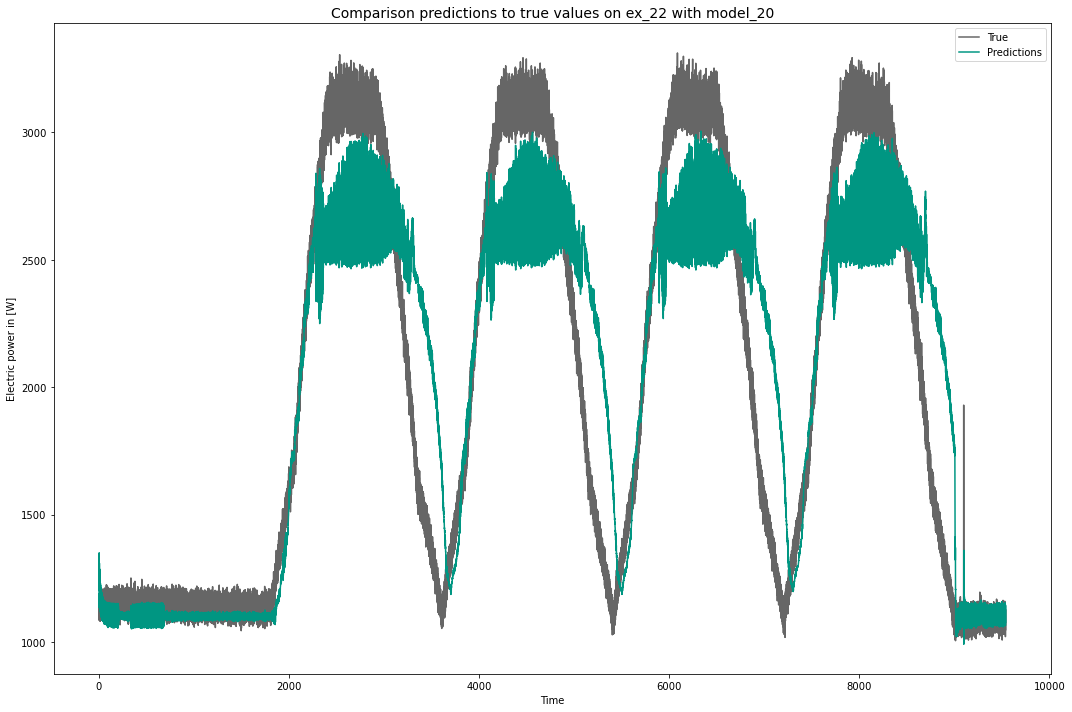

In [33]:
scaler_22, X_22, y_22, preds_scaled_22, preds_22 = predictions(ex_22, model_20, specs = " on ex_22 with model_20")

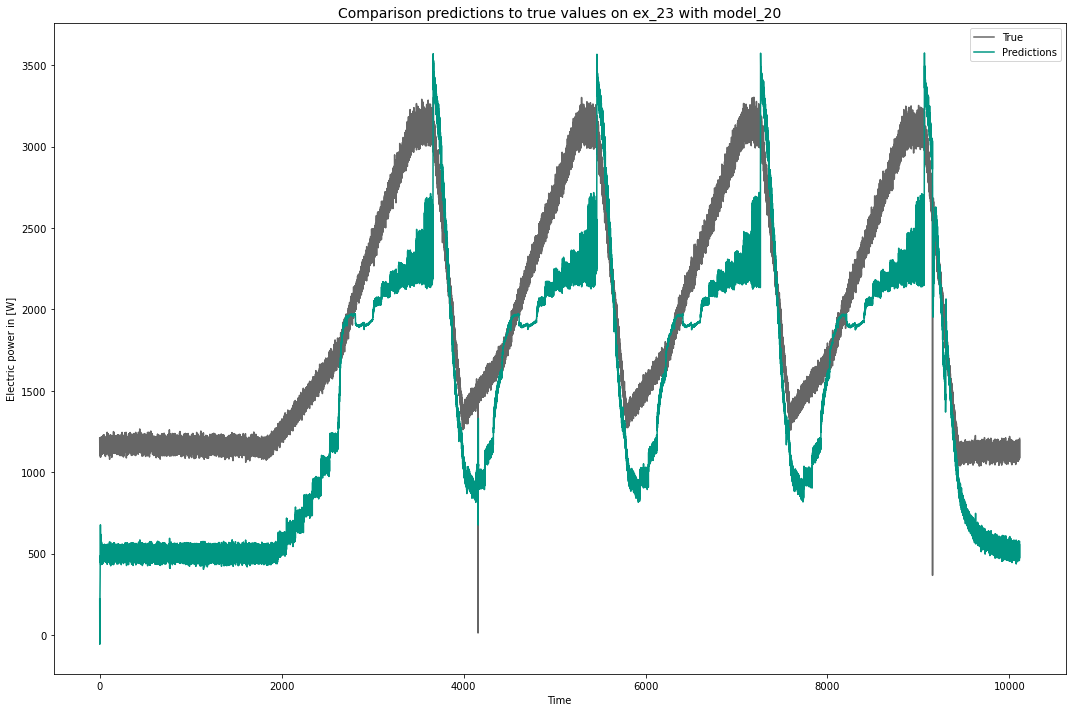

In [34]:
scaler_23, X_23, y_23, preds_scaled_23, preds_23 = predictions(ex_23, model_20, specs = " on ex_23 with model_20")

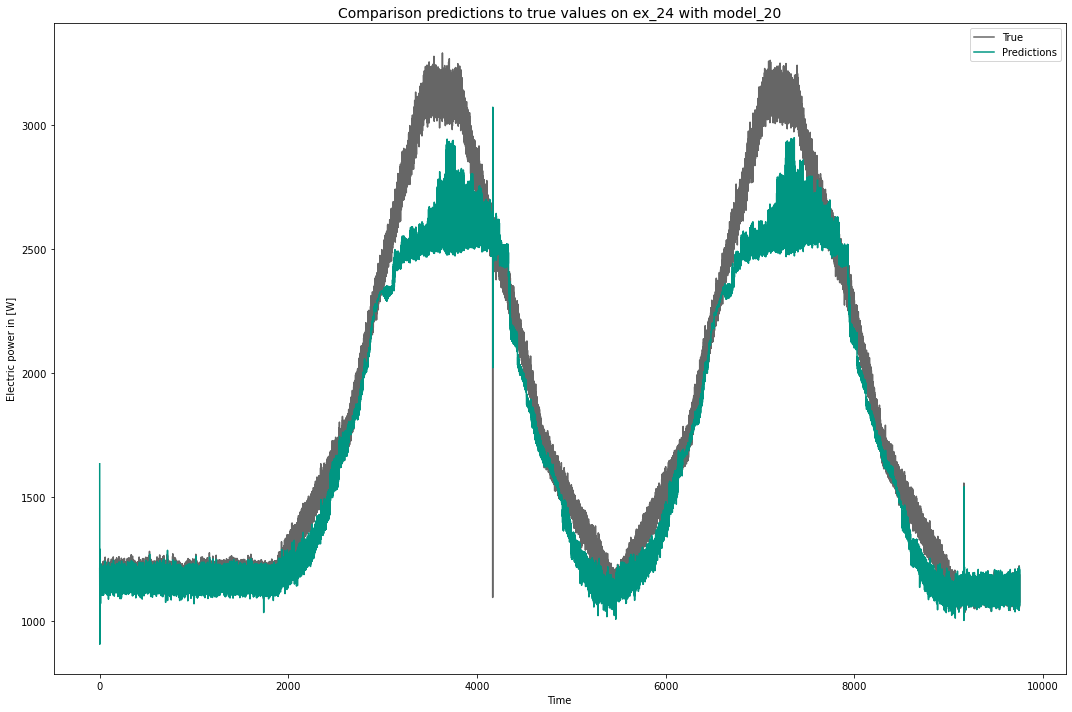

In [35]:
scaler_24, X_24, y_24, preds_scaled_24, preds_24 = predictions(ex_24, model_20, specs = " on ex_24 with model_20")

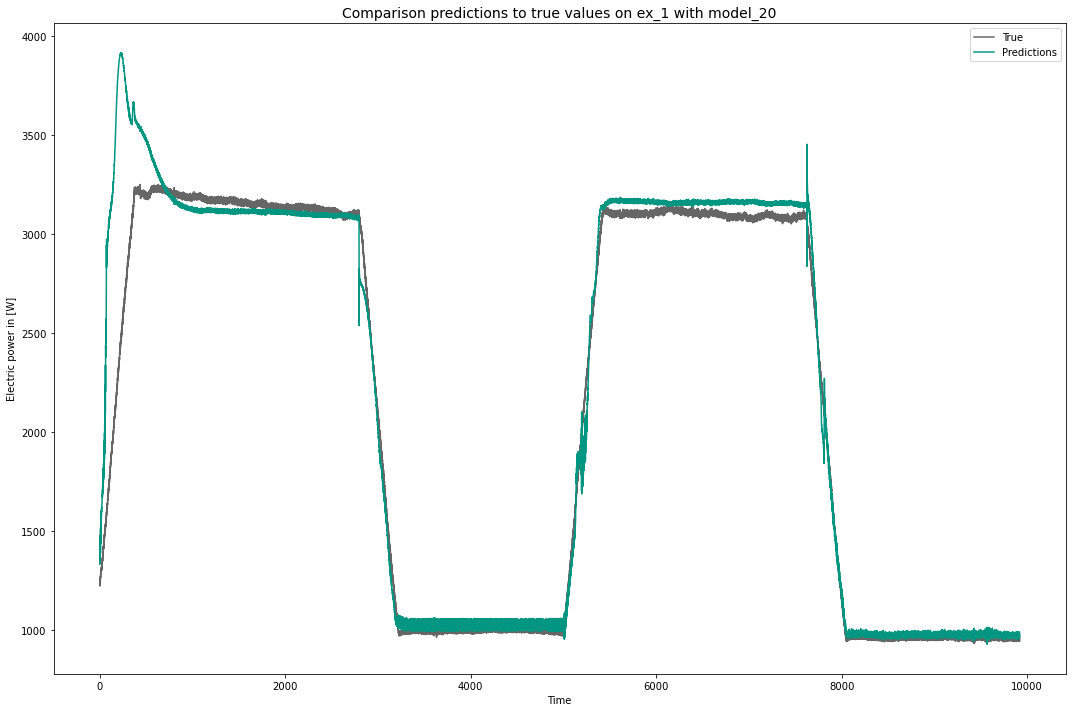

In [36]:
scaler_1, X_1, y_1, preds_scaled_1, preds_1 = predictions(ex_1, model_20, specs = " on ex_1 with model_20")

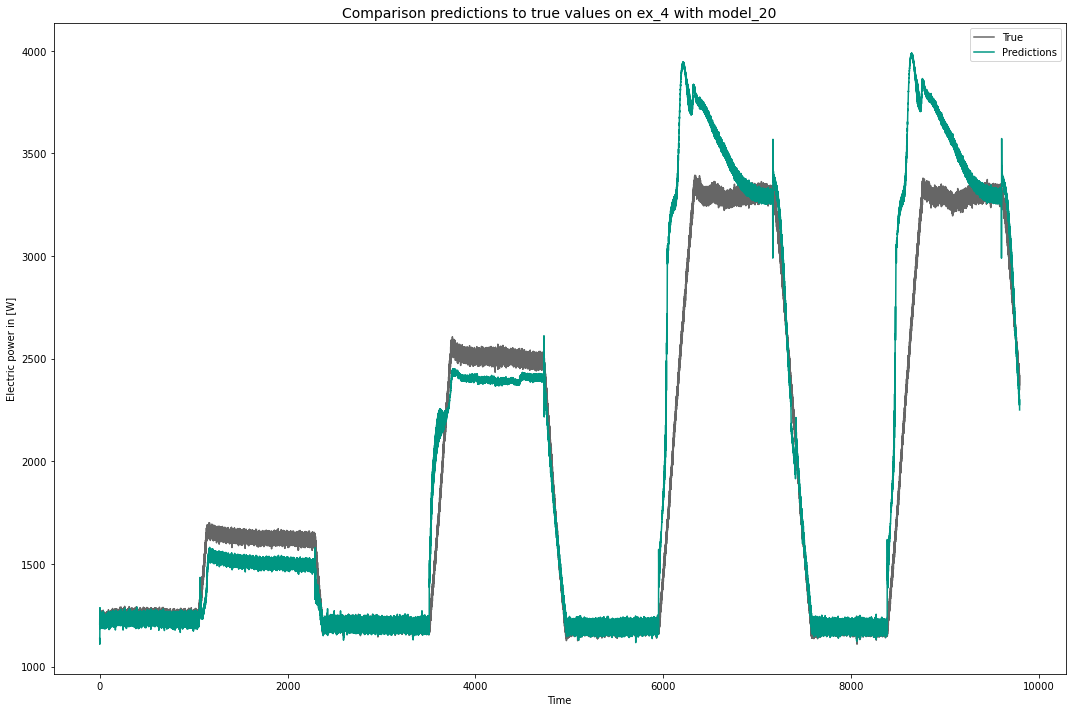

In [37]:
scaler_4, X_4, y_4, preds_scaled_4, preds_4 = predictions(ex_4, model_20, specs = " on ex_4 with model_20")

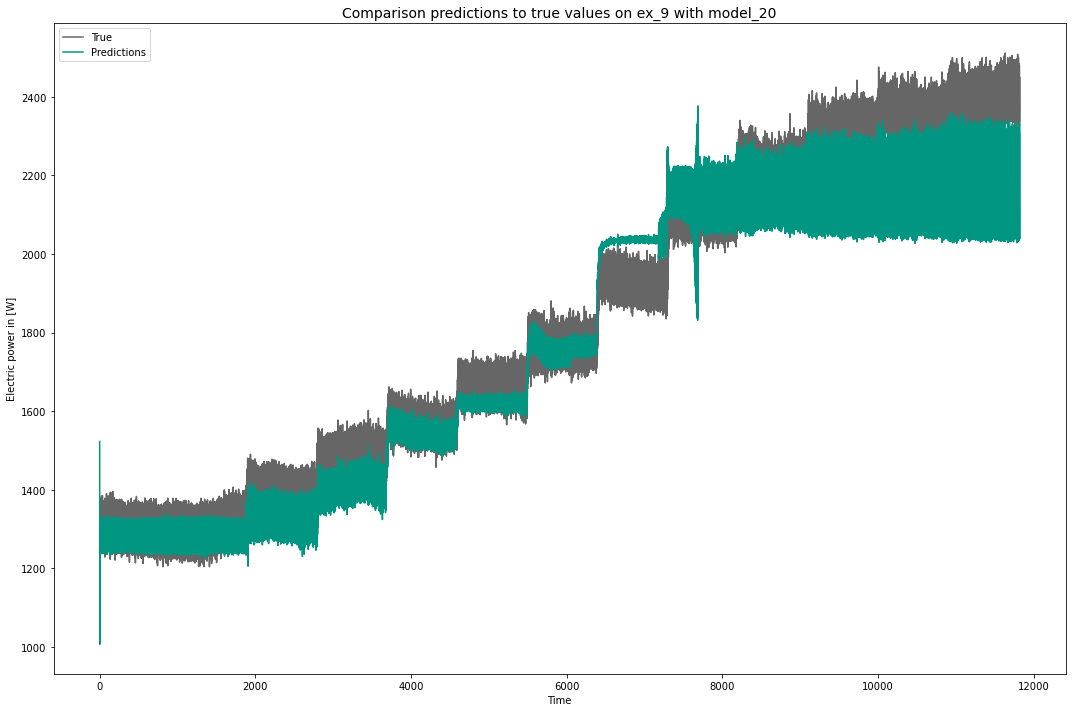

In [38]:
scaler_9, X_9, y_9, preds_scaled_9, preds_9 = predictions(ex_9, model_20, specs = " on ex_9 with model_20")